### Objective: Time Series Regression for Population

This project implements time series regression techniques for forecasting <br>
population using three different models: **SARIMAX**, **XGBoost**, and **LSTM** <br>

The workflow includes data preprocessing, model training, hyperparameter optimization, <br>
 evaluation, and visualization of the results.

### Steps
1: Data Exploration and Preprocessing <br>
2: Model Training with SARIMAX, XGBoost, and LSTM <br>
3: Evaluation Metrics and Visualization <br>
4: Deliverables <br>
<br>
<br>

1. **Data Preparation**
    - Load the population dataset.
    - Analyze seasonality and stationarity of the time series data.
    - Split the dataset into training and testing sets.

2. **Model Training**
    - Split the dataset into training and testing sets.
    - Standard Scaling ($\mu$ = 0, $\sigma$ = 1) for XGBoost and LSTM
    - Trained with SARIMAX, XGBoost (optuna), and LSTM 

3. **Evaluation**
    - Evaluate MSE (Normalized MSE), MAE (Normalized MAE), and R2
    - Visualized the prediction results

4. **Deliverables**
    - SARIMAX, and XGBoost trained models were saved to **pkl** files, <br> 
    and LSTM to **keras** file for reproducing test results.

In [187]:
# check python vsersion
!python --version

Python 3.12.2


In [188]:
%%writefile requirements.txt
pandas==2.2.2
numpy==1.26.4
seaborn==0.13.2
matplotlib==3.9.2
statsmodels==0.14.4
scikit-learn==1.5.2
xgboost==2.1.1
optuna==4.0.0
tensorflow==2.18.0
joblib==1.4.2

Overwriting requirements.txt


In [189]:
!pip install -r requirements.txt

In [114]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBRegressor
import optuna
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Input
from tensorflow.keras import metrics
import warnings
import joblib

# Suppress warnings
warnings.filterwarnings("ignore")

#### Step 1. 
- Download dataset
- The columns and their corresponding data types

In [115]:
# Load dataset
url = "https://raw.githubusercontent.com/rytakahas/TimeSeries/main/POP.csv"
df = pd.read_csv(url)

# Convert 'date' to datetime and set as index
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

In [116]:
df.head(100)

,realtime_start,value,realtime_end
date,,,
1952-01-01,2019-12-06,156309.0,2019-12-06
1952-02-01,2019-12-06,156527.0,2019-12-06
1952-03-01,2019-12-06,156731.0,2019-12-06
1952-04-01,2019-12-06,156943.0,2019-12-06
1952-05-01,2019-12-06,157140.0,2019-12-06
...,...,...,...
1959-12-01,2019-12-06,179153.0,2019-12-06
1960-01-01,2019-12-06,179386.0,2019-12-06
1960-02-01,2019-12-06,179597.0,2019-12-06


In [117]:
# Resample to daily frequency (from dayly)
df_resampled = df['value'].resample('D').interpolate(method='linear')
# Check the original and increased size of the dataset

print(f"Original dataset size: {len(df)}")
print(f"Upsampled dataset size: {len(df_resampled)}")

# Resample to monthly frequency (without losing original data points)
df_resampled_m = df['value'].resample('ME').asfreq()

# Interpolate missing values only for the new monthly points
df_resampled_m = df_resampled_m.combine_first(df['value']).interpolate(method='linear')

# Check the original and resampled size of the dataset
print(f"Original dataset size: {len(df)}")
print(f"Resampled dataset size (monthly): {len(df_resampled_m)}")



Original dataset size: 816
Upsampled dataset size: 24807
Original dataset size: 816
Resampled dataset size (monthly): 1632


#### Remarks:
    - Original dataset was only 816 rows. These are not enough to <br>
    create ML models. Therefore, I interpolated by Days for ML predictions.

In [118]:
print(df.shape)

(816, 3)


In [119]:
print(df.info)

<bound method DataFrame.info of            realtime_start       value realtime_end
date                                              
1952-01-01     2019-12-06  156309.000   2019-12-06
1952-02-01     2019-12-06  156527.000   2019-12-06
1952-03-01     2019-12-06  156731.000   2019-12-06
1952-04-01     2019-12-06  156943.000   2019-12-06
1952-05-01     2019-12-06  157140.000   2019-12-06
...                   ...         ...          ...
2019-08-01     2019-12-06  329591.333   2019-12-06
2019-09-01     2019-12-06  329785.872   2019-12-06
2019-10-01     2019-12-06  329982.035   2019-12-06
2019-11-01     2019-12-06  330154.949   2019-12-06
2019-12-01     2019-12-06  330309.946   2019-12-06

[816 rows x 3 columns]>


#### Step 2. 
- Exploratory Data Analysis (EDA): check non-seasonal features

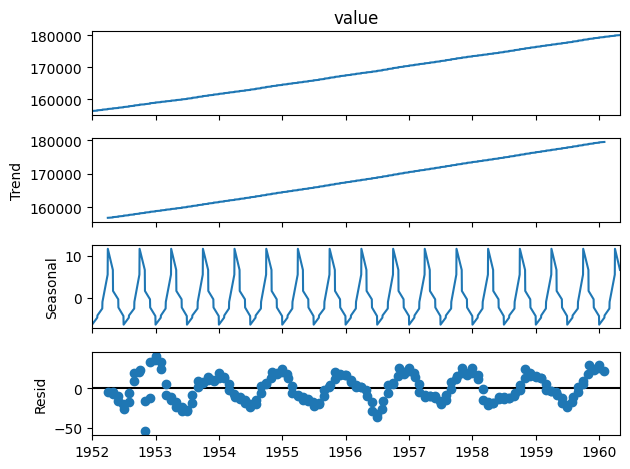

ACF and PACF for Original Data:


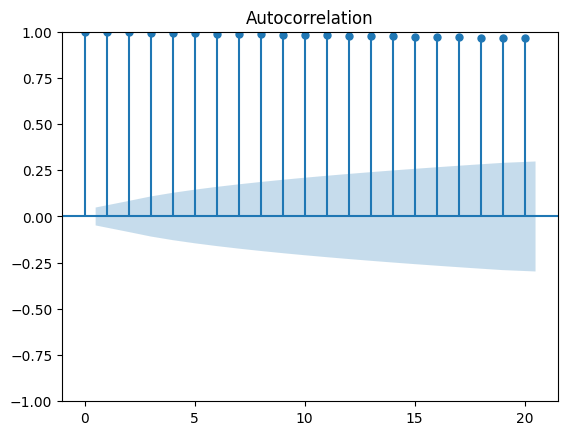

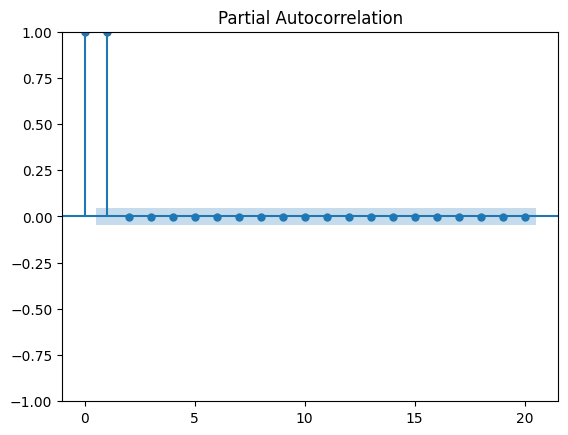

ADF Test on Original Data:
ADF Statistic: -1.4413383872962846, P-value: 0.5623054901334957
The original time series is not stationary.


In [ ]:
# Assuming `df_resampled_m` contains monthly resampled data
# Step 1: Seasonal decomposition
decomposition = seasonal_decompose(df_resampled_m.head(200).dropna(), model='additive', period=12)
decomposition.plot()
plt.show()


# Plot ACF and PACF
print("ACF and PACF for Original Data:")
plot_acf(df_resampled_m.dropna(), lags=20)
plot_pacf(df_resampled_m.dropna(), lags=20)
plt.show()

# Step 3: ADF Test for stationarity on original data
print("ADF Test on Original Data:")
adf_result = adfuller(df_resampled_m.dropna())
print(f"ADF Statistic: {adf_result[0]}, P-value: {adf_result[1]}")
if adf_result[1] < 0.05:
    print("The original time series is stationary.")
else:
    print("The original time series is not stationary.")


##### Remarks: 
    - Seasonal component shows seanonal patten, but very small
    - ACF plot shows a very slow decay, indicating non-stationarity. 
    - PACF lacks of a periodic or repeating pattern, indicating non-seasonality.
    - ADF test result also show that
      the dataset is non-stationary and non-seasonal. 

#### Step 3. 
- Build prediction models:
    split data 80% for train, 2?% for test
- Train **SARIMAX**, **XGBoost**, and **LSTM** 

In [121]:
# Train-test split
train_size = int(len(df_resampled) * 0.8)
train, test = df_resampled.iloc[:train_size], df_resampled.iloc[train_size:]
print(test.shape)


(4962,)


#### SARIMAX Model

In [122]:

# SARIMA model for forecasting
sarima_model = SARIMAX(train, order=(1, 1, 1), seasonal_order=(0, 0, 0, 0))
sarima_result = sarima_model.fit(disp=False)

# Save SARIMA model for reproducing
joblib.dump(sarima_result, 'sarima_model.pkl')


['sarima_model.pkl']

In [123]:
# Prepare data for XGBoost and LSTM
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df_resampled.values.reshape(-1, 1))

def create_features(data, look_back):
    X, y = [], []
    for i in range(look_back, len(data)):
        X.append(data[i-look_back:i])
        y.append(data[i])
    return np.array(X), np.array(y)

look_back = 20 
X, y = create_features(scaled_data, look_back)

X_train, X_test = X[:train_size - look_back], X[train_size - look_back:]
y_train, y_test = y[:train_size - look_back], y[train_size - look_back:]


#### XGBoost (with Optuna) Model 

In [124]:
# Optuna for XGBoost
def xgb_objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
    }
    xgb_model = XGBRegressor(**params)
    xgb_model.fit(X_train.reshape(X_train.shape[0], -1), y_train.ravel())
    preds = xgb_model.predict(X_test.reshape(X_test.shape[0], -1))
    return mean_squared_error(y_test, preds)

study = optuna.create_study(direction="minimize")
study.optimize(xgb_objective, n_trials=20)
best_xgb_params = study.best_params
print(f"Best XGBoost parameters: {best_xgb_params}")

# Train XGBoost with optimized parameters
xgb_model = XGBRegressor(**best_xgb_params)
xgb_model.fit(X_train.reshape(X_train.shape[0], -1), y_train.ravel())

# Save the XGBoost model
joblib.dump(xgb_model, 'xgb_model.pkl')


[I 2024-12-05 19:11:52,559] A new study created in memory with name: no-name-5a08b4c7-ac4f-4feb-b6e6-603e6ffe6ad9
[I 2024-12-05 19:11:53,179] Trial 0 finished with value: 0.015306923681736353 and parameters: {'n_estimators': 230, 'max_depth': 4, 'learning_rate': 0.01643058135741513, 'subsample': 0.7250151254002835, 'colsample_bytree': 0.8129646518594645}. Best is trial 0 with value: 0.015306923681736353.
[I 2024-12-05 19:11:53,592] Trial 1 finished with value: 0.01243808170978591 and parameters: {'n_estimators': 240, 'max_depth': 7, 'learning_rate': 0.288758905223769, 'subsample': 0.5628119397080674, 'colsample_bytree': 0.8296301668118584}. Best is trial 1 with value: 0.01243808170978591.
[I 2024-12-05 19:11:54,294] Trial 2 finished with value: 0.01253065933471579 and parameters: {'n_estimators': 233, 'max_depth': 9, 'learning_rate': 0.03048696707015877, 'subsample': 0.9576298384983153, 'colsample_bytree': 0.6973055208930545}. Best is trial 1 with value: 0.01243808170978591.
[I 2024-12

Best XGBoost parameters: {'n_estimators': 163, 'max_depth': 10, 'learning_rate': 0.219848391381467, 'subsample': 0.5081877869408873, 'colsample_bytree': 0.9677096963454047}


['xgb_model.pkl']

#### LSTM model

In [125]:
# LSTM Model
X_lstm_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_lstm_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

lstm_model = Sequential([
    Input(shape=(look_back, 1)),
    LSTM(50),
    Dense(1)
])
lstm_model.compile(optimizer='adam', loss='mse')
lstm_model.fit(X_lstm_train, y_train, epochs=10, batch_size=32, verbose=0)

# Save the LSTM model
lstm_model.save('lstm_model.keras')

#### Step 4. 
- Predictions one period $\times$ 100, display KPIs (MSE(NMSE), MAE(NMAE), R2), and plots

In [126]:
# Set forecast horizon to 100 times one perido (6 days in here)
seasonal_period = 6  # 6 dayly
forecast_horizon = 100 * seasonal_period  # 100 full periods
print(f"Forecast horizon: {forecast_horizon}")

# SARIMA forecasting
sarima_forecast = sarima_result.forecast(steps=forecast_horizon)
print(len(sarima_forecast))
# Direct XGBoost prediction
y_pred_xgb = xgb_model.predict(X_test[:forecast_horizon].reshape(forecast_horizon, -1))
y_pred_xgb = scaler.inverse_transform(y_pred_xgb.reshape(-1, 1))

# Direct LSTM prediction
# Direct LSTM prediction
y_pred_lstm = lstm_model.predict(X_test[:forecast_horizon].reshape(forecast_horizon, look_back, 1))
y_pred_lstm = scaler.inverse_transform(y_pred_lstm)

# Ensure forecasts are the same length as test[:forecast_horizon]
sarima_forecast = sarima_forecast[:forecast_horizon]
y_pred_xgb = y_pred_xgb[:forecast_horizon]
y_pred_lstm = y_pred_lstm[:forecast_horizon]


Forecast horizon: 600
600
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


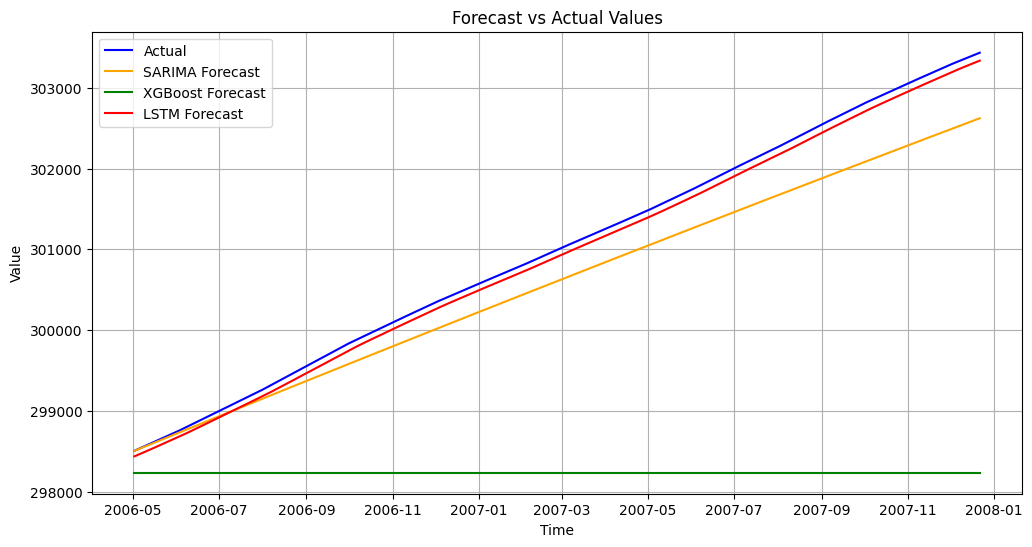

SARIMA MSE: 218267.5918278663, NMSE: 0.1076938517346811, MAE: 404.4103570668972, NMAE: 0.001343573691675601, R2: 0.8923061482653188
XGBoost MSE: 9661807.547129031, NMSE: 4.767163373892567, MAE: 2763.1623387096774, NMAE: 0.009180062180022328, R2: -3.7671633738925676
LSTM MSE: 8041.10678420785, NMSE: 0.003967504999478621, MAE: 89.21817204301061, NMAE: 0.00029640978941730635, R2: 0.9960324950005214


In [127]:
# Evaluation
test_actual = test.values[:forecast_horizon]

# Calculate KPIs (metrics)
mse_sarima = mean_squared_error(test_actual, sarima_forecast)
mse_xgb = mean_squared_error(test_actual, y_pred_xgb)
mse_lstm = mean_squared_error(test_actual, y_pred_lstm.flatten())

mae_sarima = mean_absolute_error(test_actual, sarima_forecast)
mae_xgb = mean_absolute_error(test_actual, y_pred_xgb)
mae_lstm = mean_absolute_error(test_actual, y_pred_lstm.flatten())

r2_sarima = r2_score(test_actual, sarima_forecast)
r2_xgb = r2_score(test_actual, y_pred_xgb)
r2_lstm = r2_score(test_actual, y_pred_lstm.flatten())

# Normalized MSE and MAE

# Variance of the actual data
variance_actual = np.var(test_actual)

 # Mean absolute value of the actual data
mean_absolute_actual = np.mean(np.abs(test_actual))

nmse_sarima = mse_sarima / variance_actual
nmse_xgb = mse_xgb / variance_actual
nmse_lstm = mse_lstm / variance_actual

nmae_sarima = mae_sarima / mean_absolute_actual
nmae_xgb = mae_xgb / mean_absolute_actual
nmae_lstm = mae_lstm / mean_absolute_actual

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(test.index[:forecast_horizon], test_actual, label="Actual", color="blue")
plt.plot(test.index[:forecast_horizon], sarima_forecast, label="SARIMA Forecast", color="orange")
plt.plot(test.index[:forecast_horizon], y_pred_xgb, label="XGBoost Forecast", color="green")
plt.plot(test.index[:forecast_horizon], y_pred_lstm.flatten(), label="LSTM Forecast", color="red")
plt.legend()
plt.title("Forecast vs Actual Values")
plt.xlabel("Time")
plt.ylabel("Value")
plt.grid()
plt.show()

# Print metrics
print(f"SARIMA MSE: {mse_sarima}, NMSE: {nmse_sarima}, MAE: {mae_sarima}, NMAE: {nmae_sarima}, R2: {r2_sarima}")
print(f"XGBoost MSE: {mse_xgb}, NMSE: {nmse_xgb}, MAE: {mae_xgb}, NMAE: {nmae_xgb}, R2: {r2_xgb}")
print(f"LSTM MSE: {mse_lstm}, NMSE: {nmse_lstm}, MAE: {mae_lstm}, NMAE: {nmae_lstm}, R2: {r2_lstm}")


#### Remarks:
    - XGBoost was failed to predict: The low NMAE of XGBoost indicates that errors are 
      small relative to the mean of the target variable. However, NMSE and R2 show the 
      model's predictions deviate significantly from the true values as in the plot.

#### Model Reproducibility
    - load save files
    - peform test

In [128]:
# DevOps)
# Load and reproduce predictions using the saved models

# Load the SARIMA model
sarima_result_loaded = joblib.load('sarima_model.pkl')

# Load the XGBoost model
xgb_model_loaded = joblib.load('xgb_model.pkl')

# Load the LSTM model
lstm_model_loaded = load_model('lstm_model.keras')


In [129]:
# Forecast horizon (ensure it matches the test set)
seasonal_period = 6  # One day for hourly dat
forecast_horizon = 100 * seasonal_period  # 100 full periods
print(f"Forecast horizon: {forecast_horizon}")

# SARIMA predictions (forecasting for `forecast_horizon` steps)
predictions_sarima_loaded = sarima_result_loaded.forecast(steps=forecast_horizon)

# XGBoost predictions (forecasting for `forecast_horizon` steps)
predictions_xgb_loaded = xgb_model_loaded.predict(X_test[:forecast_horizon].reshape(forecast_horizon, -1))
predictions_xgb_loaded = scaler.inverse_transform(predictions_xgb_loaded.reshape(-1, 1))

# LSTM predictions (forecasting for `forecast_horizon` steps)
predictions_lstm_loaded = lstm_model_loaded.predict(X_test[:forecast_horizon].reshape(forecast_horizon, look_back, 1))
predictions_lstm_loaded = scaler.inverse_transform(predictions_lstm_loaded)


Forecast horizon: 600
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


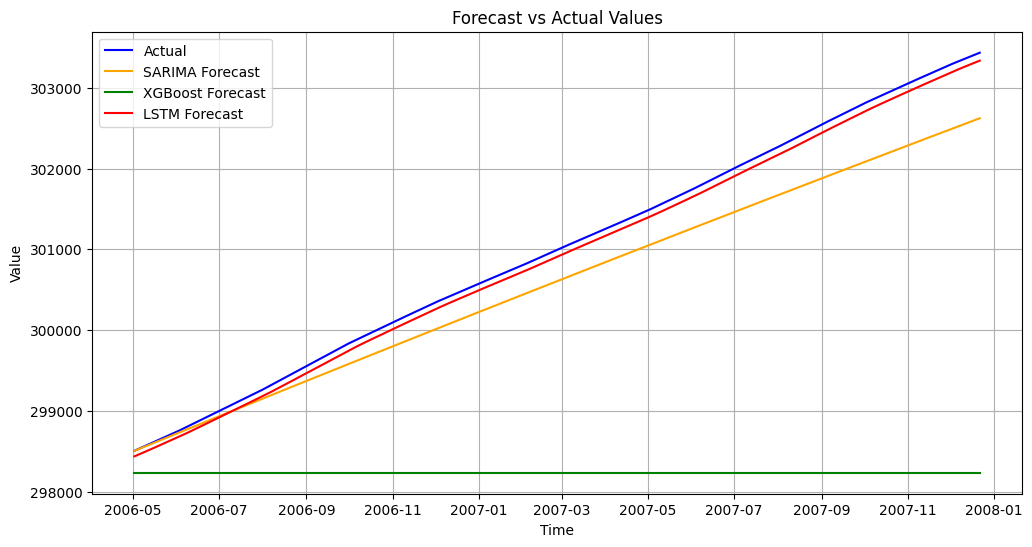

SARIMA MSE: 218267.5918278663, NMSE: 0.1076938517346811,       MAE: 404.4103570668972, NMAE: 0.001343573691675601, R2: 0.8923061482653188
XGBoost MSE: 9661807.547129031, NMSE: 4.767163373892567, MAE: 2763.1623387096774,       NMAE: 0.009180062180022328, R2: -3.7671633738925676
LSTM MSE: 8041.10678420785, NMSE: 0.003967504999478621, MAE: 89.21817204301061,       NMAE: 0.00029640978941730635, R2: 0.9960324950005214


In [130]:

# Evaluation
test_actual = test.values[:forecast_horizon]

# Calculate KPIs (metrics)
mse_sarima_loaded = mean_squared_error(test_actual, predictions_sarima_loaded)
mse_xgb_loaded = mean_squared_error(test_actual, predictions_xgb_loaded)
mse_lstm_loaded = mean_squared_error(test_actual, predictions_lstm_loaded.flatten())

mae_sarima_loaded = mean_absolute_error(test_actual, predictions_sarima_loaded)
mae_xgb_loaded = mean_absolute_error(test_actual, predictions_xgb_loaded)
mae_lstm_loaded = mean_absolute_error(test_actual, predictions_lstm_loaded.flatten())

r2_sarima_loaded = r2_score(test_actual, predictions_sarima_loaded)
r2_xgb_loaded = r2_score(test_actual, predictions_xgb_loaded)
r2_lstm_loaded = r2_score(test_actual, predictions_lstm_loaded.flatten())

# Normalized MSE and MAE

# Variance of the actual data
variance_actual = np.var(test_actual)

 # Mean absolute value of the actual data
mean_absolute_actual = np.mean(np.abs(test_actual))

nmse_sarima_loaded = mse_sarima_loaded / variance_actual
nmse_xgb_loaded = mse_xgb_loaded / variance_actual
nmse_lstm_loaded = mse_lstm_loaded / variance_actual

nmae_sarima_loaded = mae_sarima_loaded / mean_absolute_actual
nmae_xgb_loaded = mae_xgb_loaded / mean_absolute_actual
nmae_lstm_loaded = mae_lstm_loaded / mean_absolute_actual

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(test.index[:forecast_horizon], test_actual, label="Actual", color="blue")
plt.plot(test.index[:forecast_horizon], predictions_sarima_loaded, label="SARIMA Forecast", color="orange")
plt.plot(test.index[:forecast_horizon], predictions_xgb_loaded, label="XGBoost Forecast", color="green")
plt.plot(test.index[:forecast_horizon], predictions_lstm_loaded.flatten(), label="LSTM Forecast", color="red")
plt.legend()
plt.title("Forecast vs Actual Values")
plt.xlabel("Time")
plt.ylabel("Value")
plt.grid()
plt.show()

# Print metrics
print(f"SARIMA MSE: {mse_sarima_loaded}, NMSE: {nmse_sarima_loaded}, \
      MAE: {mae_sarima_loaded}, NMAE: {nmae_sarima_loaded}, R2: {r2_sarima}")
print(f"XGBoost MSE: {mse_xgb_loaded}, NMSE: {nmse_xgb_loaded}, MAE: {mae_xgb_loaded}, \
      NMAE: {nmae_xgb_loaded}, R2: {r2_xgb}")
print(f"LSTM MSE: {mse_lstm_loaded}, NMSE: {nmse_lstm_loaded}, MAE: {mae_lstm_loaded}, \
      NMAE: {nmae_lstm_loaded}, R2: {r2_lstm}")

#### Remarks: These were reproducing the above **SARIMA**, **XGBoost**, and **LSTM** results